In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np;
import pandas as pandas;
from scipy import ndimage
from torchvision import datasets, transforms
from torch.distributions import normal
from torch.distributions import multivariate_normal
import matplotlib.pyplot as plt

In [ ]:
torch.set_default_tensor_type(torch.DoubleTensor)

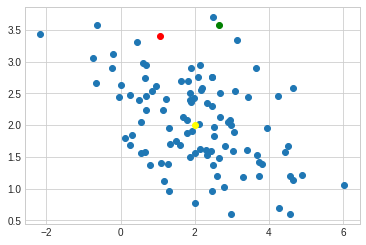


**************** Distancia euclidiana U,Y1 ****************
tensor(1.6919)

**************** Distancia euclidiana U,Y2 ****************
tensor(1.6992)

**************** ****************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
'''
Creates data with gaussian distribution
'''
def create_data_one_mode(mean, covarianceMatrix, numberSamples):
    # Inits the bi gaussian data generator
    multiGaussGenerator = multivariate_normal.MultivariateNormal(mean, covarianceMatrix)
    # Takes the samples
    samples = multiGaussGenerator.sample(torch.Size([numberSamples]))
    samples = samples.type(torch.DoubleTensor)
    return samples


covarianceMatrix = torch.tensor([[2, -0.5], [-0.5, 0.5]])
mean = torch.tensor([2.0, 2.0])
X = create_data_one_mode(mean = mean, covarianceMatrix = covarianceMatrix, numberSamples = 100)
plt.scatter(X[:, 0], X[:, 1])

#data example
mu = mean
y1 = torch.tensor([1.05, 3.4])
y2 = torch.tensor([2.65, 3.57])
plt.scatter(y1[0], y1[1],c = 'red')
plt.scatter(y2[0], y2[1],c = 'green')
plt.scatter(mean[0], mean[1], c = 'yellow')
plt.show()


#calcular las distancias Euclidianas
""" ---------------------------------------------      Distance
"""
def distance(v1,v2):
  ten1=torch.tensor(v1)
  ten2=torch.tensor(v2)

  dis=ten2-ten1

  return (dis)

eu_dist_uy1= torch.norm(distance(mu,y1),2)
eu_dist_uy2= torch.norm(distance(mu,y2),2)
print("\n**************** Distancia euclidiana U,Y1 ****************")
print(eu_dist_uy1)
print("\n**************** Distancia euclidiana U,Y2 ****************")
print(eu_dist_uy2)
print("\n**************** ****************")



*   2



In [ ]:
def calcular_blanqueo_PCA1(X, y1, y2):
  X = X.transpose(0,1)
  mean1 = torch.mean(X, 1, True)
  res = mean1-X
  covMatrix = 1/(X.shape[1]-1 ) * res.mm(res.transpose(0,1))

  print("\n**************** COVARIANCE MATRIX ****************")
  print(covMatrix)

  return

calcular_blanqueo_PCA1(X, y1, y2)

print(covarianceMatrix)


**************** COVARIANCE MATRIX ****************
tensor([[ 2.1316, -0.4704],
        [-0.4704,  0.4876]])
tensor([[ 2.0000, -0.5000],
        [-0.5000,  0.5000]])


In [ ]:
def calculateEigenvectorsAndValues(dataset, n):
  """
  param dataset, dataset used to calculate its covariance matrix
  param n, number of eigen vectors to extract
  """
  #use numpy cov function to calculate the covariance matrix
  Sigma = torch.tensor(np.cov(dataset.transpose(0,1).numpy()))
  
  
  #one eigen value per row, and its corresponding eigenvector per column
  EigenValues, EigenVectors = torch.eig(Sigma ,eigenvectors=True)
 
  return (EigenValues, EigenVectors)

_, EigenVectors = calculateEigenvectorsAndValues(X, 2)
EigenVectors

tensor([[ 0.9706,  0.2408],
        [-0.2408,  0.9706]])

In [ ]:
U = (X - mu)
U

In [ ]:
def reduceDataDimensionality(dataset, baseVectors):
  """
  Project the dataset using the base vectors
  param dataset, dataset to project
  param basevectors, base vectors to use, one base vector per column
  """ 
  numDataSamples = dataset.shape[0]
  
  #substract the mean to the data for data normalization
  mu = torch.mean(dataset, 0)
  dataset = dataset - mu
  print("mean tensor")
  print(mu)

  dataset2D = dataset.mm(baseVectors)
  
    
  return dataset2D


EigenVectors1 = torch.zeros(EigenVectors.shape[0], 2)
EigenVectors1[:,0] = EigenVectors[:,0] / covarianceMatrix[0,0]
EigenVectors1[:,1] = EigenVectors[:,1] / covarianceMatrix[1,1]
U_proy = reduceDataDimensionality(X, EigenVectors1)
U_proy

mean tensor
tensor([1.8540, 1.8868])


tensor([[1.0500, 3.4000]])

In [ ]:
w1 = y1 - mu
w2 = y2 - mu

print(w1)

y1_proy = torch.zeros(1,2)
y2_proy = torch.zeros(1,2)

y1_proy[0,0] = w1.dot(EigenVectors1[:,0])
y1_proy[0,1] = w2.dot(EigenVectors1[:,0])
y2_proy[0,0] = w1.dot(EigenVectors1[:,1])
y2_proy[0,1] = w2.dot(EigenVectors1[:,1])

w1 = torch.reshape(w1, (1,2))
w2 = torch.reshape(w2, (1,2))

W = torch.cat((w1,w2), 0)

dataset2D_w = W.mm(EigenVectors1)
print(dataset2D_w)
print(y1_proy)
print(y2_proy)

tensor([-0.9500,  1.4000])
tensor([[-0.6296,  2.2600],
        [ 0.1264,  3.3607]])
tensor([[-0.6296,  0.1264]])
tensor([[2.2600, 3.3607]])


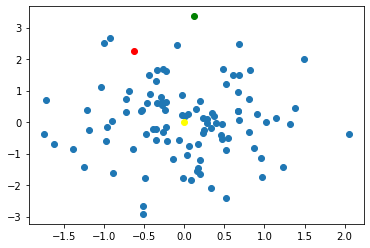

In [ ]:
plt.scatter(U_proy[:, 0], U_proy[:, 1])
plt.scatter(dataset2D_w[0,0], dataset2D_w[0,1],c = 'red')
plt.scatter(dataset2D_w[1,0], dataset2D_w[1,1],c = 'green')
plt.scatter(0., 0., c = 'yellow')
plt.show()

In [ ]:
def calCovMx(X):
  X = X.transpose(0,1)
  mean1 = torch.mean(X, 1, True)
  res = mean1-X
  covMatrix = 1/(X.shape[1]-1 ) * res.mm(res.transpose(0,1))
  print(covMatrix)

calCovMx(U_proy)

tensor([[5.3125e-01, 3.6165e-17],
        [3.6165e-17, 1.3053e+00]])


In [ ]:
mean_x = torch.mean(U_proy[:,0])
mean_y =torch.mean(U_proy[:,1])

print(mean_x)
print(mean_y)

mu_proy = torch.tensor([0., 0.])
y1_proy = torch.tensor([dataset2D_w[0,0], dataset2D_w[0,1]])
y2_proy = torch.tensor([dataset2D_w[1,0], dataset2D_w[1,1]])


eu_dist_uy1_proy= torch.norm(distance(mu_proy,y1_proy),2)
eu_dist_uy2_proy= torch.norm(distance(mu_proy,y2_proy),2)
print("\n**************** Distancia euclidiana U,Y1 ****************")
print(eu_dist_uy1_proy)
print("\n**************** Distancia euclidiana U,Y2 ****************")
print(eu_dist_uy2_proy)
print("\n**************** ****************")

tensor(7.5495e-17)
tensor(4.2633e-16)

**************** Distancia euclidiana U,Y1 ****************
tensor(2.3461)

**************** Distancia euclidiana U,Y2 ****************
tensor(3.3630)

**************** ****************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).




*   3




In [ ]:
def calcular_distancia_Mahalanobis(vector1, vector2):
  trans = (vector1-vector2).transpose(0, 1)
  inv = torch.inverse(covarianceMatrix)
  norm = vector1-vector2
  print(np.sqrt(trans.mm(inv).mm(norm)))
  return

mu_1 = torch.reshape(mu, (1,2)).transpose(0,1)
y_1 = torch.reshape(y1, (1,2)).transpose(0,1)
y_2 = torch.reshape(y2, (1,2)).transpose(0,1)

calcular_distancia_Mahalanobis(mu_1, y_1)
calcular_distancia_Mahalanobis(mu_1, y_2)

tensor([[2.0137]])
tensor([[2.8663]])




*   4



/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


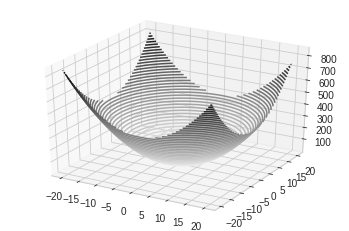

In [ ]:

%matplotlib inline
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

def f(x, y):
  ope = (x-0.7)**2 + (y-0.5)**2
  return ope

x = np.linspace(-20, 20, 30)
y = np.linspace(-20, 20, 30)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')

In [ ]:
def grad(x1, x2):
  grad = torch.tensor([2.*(x1-0.7), 2.*(x2-0.5)])
  return grad

grad(0.,0.)

tensor([-1.4000, -1.0000])

In [ ]:
alpha = 0.1
x0 = torch.tensor([20., 20.]) #Initial guess
N = 100 # Maximum number of iterations
tol = 1e-4 # Convergence tolerance
x = torch.zeros(N + 1,2) # Preallocate solution vector where row => iteration
x[0] = x0 # Set initial guess

n = 1
nfinal = N # Store final iteration if tol is reached before N iterations
while (n <= N): 
  x[n] = x[n - 1] - alpha * grad(x[n-1,0], x[n-1,1])
  if (abs((np.sqrt(grad(x[n-1,0], x[n-1,1])[0]**2+grad(x[n-1,0], x[n-1,1])[1]**2))) <= tol):
      nfinal = n # Store final iteration
      break
  n = n + 1

print(x[:65,:])
print(nfinal)

tensor([[20.0000, 20.0000],
        [16.1400, 16.1000],
        [13.0520, 12.9800],
        [10.5816, 10.4840],
        [ 8.6053,  8.4872],
        [ 7.0242,  6.8898],
        [ 5.7594,  5.6118],
        [ 4.7475,  4.5894],
        [ 3.9380,  3.7716],
        [ 3.2904,  3.1172],
        [ 2.7723,  2.5938],
        [ 2.3579,  2.1750],
        [ 2.0263,  1.8400],
        [ 1.7610,  1.5720],
        [ 1.5488,  1.3576],
        [ 1.3791,  1.1861],
        [ 1.2432,  1.0489],
        [ 1.1346,  0.9391],
        [ 1.0477,  0.8513],
        [ 0.9781,  0.7810],
        [ 0.9225,  0.7248],
        [ 0.8780,  0.6799],
        [ 0.8424,  0.6439],
        [ 0.8139,  0.6151],
        [ 0.7911,  0.5921],
        [ 0.7729,  0.5737],
        [ 0.7583,  0.5589],
        [ 0.7467,  0.5471],
        [ 0.7373,  0.5377],
        [ 0.7299,  0.5302],
        [ 0.7239,  0.5241],
        [ 0.7191,  0.5193],
        [ 0.7153,  0.5154],
        [ 0.7122,  0.5124],
        [ 0.7098,  0.5099],
        [ 0.7078,  0

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


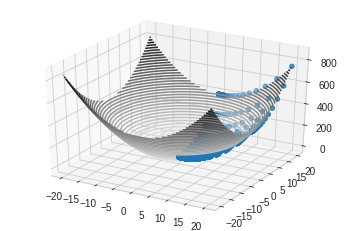

In [ ]:
X1, Y1 = np.meshgrid(x[:,0].numpy(), x[:,1].numpy())

Z1 = f(X1, Y1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.scatter(X1, Y1, Z1, cmap='summer')

**Newton-Raphson 1**

In [ ]:
x0 = torch.tensor([20., 20.]) #Initial guess
N = 10 # Maximum number of iterations
tol = 1e-4 # Convergence tolerance
x = torch.zeros(N + 1,2) # Preallocate solution vector where row => iteration
x[0] = x0 # Set initial guess
hess = 2*torch.eye(2,2)

n = 1
nfinal = N # Store final iteration if tol is reached before N iterations
while (n <= N): 
  x[n] = x[n - 1] - torch.reshape(grad(x[n-1,0], x[n-1,1]), (1,2)).mm(torch.inverse(hess))
  if (abs((np.sqrt(grad(x[n-1,0], x[n-1,1])[0]**2+grad(x[n-1,0], x[n-1,1])[1]**2))) <= tol):
      nfinal = n # Store final iteration
      break
  n = n + 1

print(x)
print(nfinal)

tensor([[20.0000, 20.0000],
        [ 0.7000,  0.5000],
        [ 0.7000,  0.5000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000]])
2


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


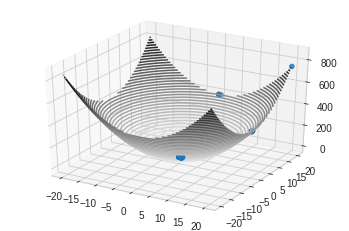

In [ ]:
X1, Y1 = np.meshgrid(x[:,0].numpy(), x[:,1].numpy())

Z1 = f(X1, Y1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.scatter(X1, Y1, Z1, cmap='summer')

**Newton-Raphson 2**

In [ ]:
def grad(x1, x2):
  grad = torch.tensor([np.exp(-x1**2-x2**2)*(1-2*x1**2), -2*x1*x2*np.exp(-x1**2-x2**2)])
  return grad


def hess(x1, x2):
  hess = torch.tensor([[2*x1*np.exp(-x1**2-x2**2)*(2*x1**2-4*x1-1), -2*x2*np.exp(-x1**2-x2**2)*(1-2*x1**2)], 
                       [2*x2*np.exp(-x1**2-x2**2)*(-1+2*x1**2), 2*x1*np.exp(-x1**2-x2**2)*(-1+2*x2**2)]])
  return hess

hess(2., 2.)

tensor([[-0.0013,  0.0094],
        [ 0.0094,  0.0094]])

In [ ]:
x0 = torch.tensor([.5, .5]) #Initial guess
N = 100 # Maximum number of iterations
tol = 1e-4 # Convergence tolerance
x = torch.zeros(N + 1,2) # Preallocate solution vector where row => iteration
x[0] = x0 # Set initial guess

n = 1
nfinal = N # Store final iteration if tol is reached before N iterations
while (n <= N): 
  x[n] = x[n - 1] + torch.reshape(grad(x[n-1,0], x[n-1,1]), (1,2)).mm(torch.inverse(hess(x[n-1,0], x[n-1,1])))
  if (abs((np.sqrt(grad(x[n-1,0], x[n-1,1])[0]**2+grad(x[n-1,0], x[n-1,1])[1]**2))) <= tol):
      nfinal = n # Store final iteration
      break
  n = n + 1

print(x[:15,:])
print(nfinal)

tensor([[ 5.0000e-01,  5.0000e-01],
        [-1.1102e-16,  2.0000e+00],
        [-1.2490e-16,  1.7500e+00],
        [-1.4529e-16,  1.4643e+00],
        [-1.7917e-16,  1.1228e+00],
        [-2.5023e-16,  6.7752e-01],
        [-5.2280e-16, -6.0474e-02],
        [-7.2000e-14,  8.2075e+00],
        [-7.2534e-14,  8.1466e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00]])
8
